# LIME - Local Interpretable Model-Agnostic Explanations


#### Code inspired by:     Cristian Arteaga:                                                                                                                                                                                   https://nbviewer.org/url/arteagac.github.io/blog/lime_image.ipynb
#### Adapted and interpreted by: Team Kovac - DP2 - WS 2021/2022

---
In this notebook, we will try to use LIME and explain how the **FER** algorithm (https://pypi.org/project/fer/) works when making decisions on which emotion category is the most dominant. We will take two different images - `grayscale` and `coloured`. The `grayscale` image is from the **FER2013** (https://www.kaggle.com/msambare/fer2013) dataset, whereas the `coloured` image is from the **Google dataset** (https://research.google/tools/datasets/google-facial-expression/).

We tried using the `lime` package (https://lime-ml.readthedocs.io/en/latest/lime.html#), as well as the source code (https://github.com/marcotcr/lime/tree/master/lime). However, we encountered many challenges and issues with the package, since our model does not fit the description of the classifier that the `lime.lime_image.LimeImageExplainer`'s `explain_instance` (https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image) takes as an argument. Because of that, we decided to try and recreate LIME manually and explain it as much as we can on the two images. For this, we have used the above mentioned code as an inspiration and adapted it to fit our purposes and model. 

** NOTE: Most of the code below is done based on our understanding and interpretation of LIME and is not to be considered as facts.

In [1]:
#Installing the necessary packages
import sys
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install FER
!{sys.executable} -m pip install opencv-python

In [2]:
#Importing all the packages necessary for the FER to work, as well as for importing the image.
import tensorflow 
%matplotlib inline 
import matplotlib.pyplot as plt # Visualisations
from fer import FER # Facial recognition
import numpy as np # Arrays
import cv2 # Image import, 

import requests # HTTP 
import urllib.request
from PIL import Image # Plotting
import numpy as np
import skimage # For visualizations and later image segmentation
from skimage import data, io, filters
import random
random.seed(1234)
np.random.seed(1234)

---
## Step 1 - Loading images

In this notebook, we will try both one `grayscale` image, as well as one `coloured` image. 

`Grayscale` image:

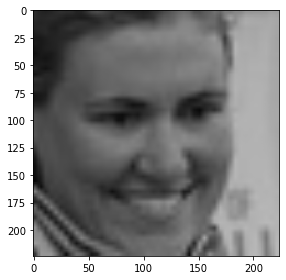

In [3]:
# Loading grayscale image
gray = "./FER/lime/grayscale.jpg"
grayscale_test = cv2.imread(gray)
img_size = 224
new_array_gray = cv2.resize(grayscale_test, (img_size, img_size)) #Resizing images, as done in the 0.final_notebook.ipynb
gray_resized = cv2.cvtColor(new_array_gray, cv2.COLOR_BGR2RGB)
skimage.io.imshow(gray_resized) 
plt.show()

---
`Coloured` image:

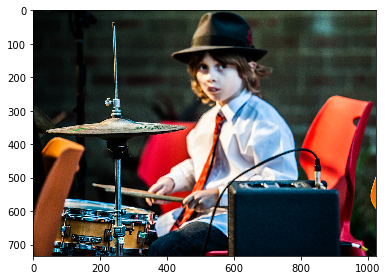

In [4]:
# Loading coloured image
coloured_img = skimage.io.imread("https://farm4.staticflickr.com/3679/12137399835_d9075d3194_b.jpg")
skimage.io.imshow(coloured_img) 
plt.show()

---
## Step 2 - Using the `FER` model

#### Top 5 emotion categories that the `FER` model recognizes:

`Grayscale` image:

In [5]:
import operator
import os
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR) # Disabling tensorflow WARNING
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

emo_detector_gray = FER(mtcnn = True)
captured_emotions_gray = emo_detector_gray.detect_emotions(gray_resized)

# Print all captured emotions with the image
print(captured_emotions_gray)

emotions_gray = []
for dicto in captured_emotions_gray:
    dominant_gray = max(dicto['emotions'].values())
    for emotion, score in dicto['emotions'].items():
        if score == dominant_gray:
            emotions_gray.append(emotion)
            
x = dict(sorted(captured_emotions_gray[0]['emotions'].items(), key=operator.itemgetter(1), reverse=True)[:5])
print("Top 5 classes: ", x)

[{'box': (-7, 11, 204, 204), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 1.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}]
Top 5 classes:  {'happy': 1.0, 'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'sad': 0.0}


For the `grayscale` image we have used in this case, the top emotion category that FER recognizes is **happy**, with the probability of **100%**. It is indeed the image we have used from the `fer2013` train data with the label **happy**.

---
`Coloured` image:

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

emo_detector_colour = FER(mtcnn = True)
captured_emotions_colour = emo_detector_colour.detect_emotions(coloured_img)

# Print all captured emotions with the image
print(captured_emotions_colour)

emotions_colour = []
for dicto in captured_emotions_colour:
    dominant_colour = max(dicto['emotions'].values())
    for emotion, score in dicto['emotions'].items():
        if score == dominant_colour:
            emotions_colour.append(emotion)
            
y = dict(sorted(captured_emotions_colour[0]['emotions'].items(), key=operator.itemgetter(1), reverse=True)[:5])
print("Top 5 classes: ", y)

[{'box': (474, 116, 157, 157), 'emotions': {'angry': 0.01, 'disgust': 0.0, 'fear': 0.04, 'happy': 0.11, 'sad': 0.03, 'surprise': 0.66, 'neutral': 0.16}}]
Top 5 classes:  {'surprise': 0.66, 'neutral': 0.16, 'happy': 0.11, 'fear': 0.04, 'sad': 0.03}


For the coloured image we have used in this case, the top emotion category that FER recognizes is **surprise**, with the probability of **66%**. This image is from the **Google dataset**. Other than **surprise**, it recognizes **neutral** and **happy**, amongst other emotions.

---
## Step 3 - Image segmentation

We will segment our images using `skimage.segmentation` that "segments image using quickshift clustering in Color-(x,y) space" (https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.quickshift). Number of perturbations we have chosen is 100, so for 100 perturbations the segmentation is done. Function perturb_image returns a perturbed image for each perturbation, which will later be used in predictions and visualisation.

We want to check for segments in each perturbation, which makes the most importance to the FER to decide on a specific emotion.

`Grayscale` image segmentation:

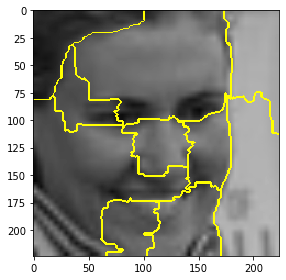

In [7]:
import skimage.segmentation
np.random.seed(1234)

superpixels_gray = skimage.segmentation.quickshift(gray_resized, kernel_size = 7, max_dist = 100, ratio = 0.5)
num_superpixels_gray = np.unique(superpixels_gray).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(gray_resized, superpixels_gray))

#Generate perturbations
num_perturb_gray = 100
perturbations_gray = np.random.binomial(1, 0.5, size=(num_perturb_gray, num_superpixels_gray))

#Create function to apply perturbations to images
import copy
def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image.astype('uint8')

#### This is an example of the perturbations as well as the visualisation of the perturbed `grayscale` image:

Perturbation 6 for the grayscale image is:  [0 1 1 0 1 1 1 1 1 1]


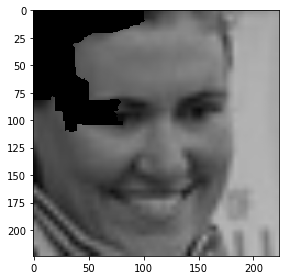

In [8]:
print('Perturbation 6 for the grayscale image is: ', perturbations_gray[5]) 
img_test_gray = perturb_image(gray_resized, perturbations_gray[5], superpixels_gray)
skimage.io.imshow(img_test_gray)
plt.show()

---
`Coloured` image segmentation:

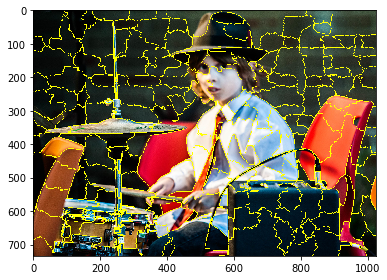

In [9]:
import skimage.segmentation
np.random.seed(1234)

superpixels = skimage.segmentation.quickshift(coloured_img, kernel_size = 7, max_dist = 300, ratio = 0.8)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(coloured_img, superpixels))

#Generate perturbations
num_perturb = 100
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

#### This is an example of the perturbations as well as the visualisation of the perturbed `coloured` image:

Perturbation 6 for the coloured image is: 
[1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0
 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1
 1 1 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 0
 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1
 0 1]


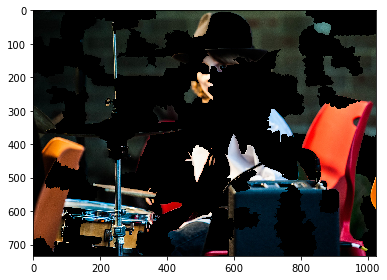

In [10]:
print('Perturbation 6 for the coloured image is: ')
print(perturbations[5]) 
img_test_colour = perturb_image(coloured_img, perturbations[5], superpixels)
skimage.io.imshow(img_test_colour)
plt.show()

---
## Step 4 - Using `FER` model for each perturbation
For each perturbation, a perturbed image is created and **FER** model is implemented using these perturbed images. Empty list will indicate that the **FER** model cannot identify emotions because the Haar-Cascade Classifier and MTCNN (used in the source code of fer for detecting face bounding boxes) cannot detect the face bounding box, because the face is fully or mostly covered.

`Grayscale` image:

In [11]:
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

gray_predictions = []
for pert in perturbations_gray:
    perturbed_img_gray = perturb_image(gray_resized, pert, superpixels_gray)
    emo_gray = FER(mtcnn = True)
    pred_gray = emo_gray.detect_emotions(perturbed_img_gray)
    gray_predictions.append(pred_gray)
        
print(gray_predictions)

[[], [{'box': (-6, 15, 198, 198), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 1.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}], [{'box': (11, 9, 210, 210), 'emotions': {'angry': 0.25, 'disgust': 0.0, 'fear': 0.02, 'happy': 0.64, 'sad': 0.03, 'surprise': 0.03, 'neutral': 0.03}}], [], [], [{'box': (-6, 7, 210, 210), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 1.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}], [], [], [], [{'box': (-5, 20, 193, 193), 'emotions': {'angry': 0.67, 'disgust': 0.0, 'fear': 0.04, 'happy': 0.23, 'sad': 0.02, 'surprise': 0.03, 'neutral': 0.01}}], [], [], [], [], [], [{'box': (-13, 2, 218, 218), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 1.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}], [{'box': (-7, 16, 202, 202), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 1.0, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}], [], [], [], [{'box': (34, 31, 170, 170), 'emotions': {'angry': 

---
`Coloured` image:

In [12]:
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

colour_predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(coloured_img, pert, superpixels)
    emo = FER(mtcnn = True)
    pred_colour = emo.detect_emotions(perturbed_img)
    colour_predictions.append(pred_colour)
        
print(colour_predictions)

[[{'box': (482, 119, 153, 153), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.02, 'sad': 0.1, 'surprise': 0.05, 'neutral': 0.83}}], [{'box': (466, 115, 168, 168), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.03, 'happy': 0.05, 'sad': 0.03, 'surprise': 0.64, 'neutral': 0.25}}], [{'box': (482, 132, 138, 138), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.25, 'sad': 0.02, 'surprise': 0.4, 'neutral': 0.32}}], [{'box': (490, 136, 130, 130), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.19, 'sad': 0.02, 'surprise': 0.43, 'neutral': 0.35}}], [{'box': (468, 134, 130, 130), 'emotions': {'angry': 0.13, 'disgust': 0.0, 'fear': 0.26, 'happy': 0.01, 'sad': 0.09, 'surprise': 0.19, 'neutral': 0.32}}], [{'box': (467, 129, 133, 133), 'emotions': {'angry': 0.24, 'disgust': 0.0, 'fear': 0.22, 'happy': 0.01, 'sad': 0.09, 'surprise': 0.12, 'neutral': 0.32}}], [], [{'box': (482, 120, 153, 153), 'emotions': {'angry': 0.0, 'disgust': 0.

---
## Step 5 - Euclidean distance

In this step, we will calculate Euclidean distance between top emotion category recognized by the FER model in each perturbation and the top emotion category with all superpixels enabled (**happy** for the `grayscale`image and **surprise** for `coloured` image). In the code used for inspiration, another distance metrics is used (Cosine distance). In our opinion, Cosine similarity (1 - Cosine distance) does not make sense, especially in the case of `grayscale` image. That image is zoomed in, so the face bounding box (recognized using Haar-Cascade, as well as MTCNN for more accurate results) would be almost always the same for each perturbed image, where **FER** model can actually recognize emotions.

The Euclidean distance metrics we will use in this case, should help us find the part/parts of the image that has/have influenced the decision of **FER** model the most. The lower the Euclidean distance, the more relevant are the parts of the face for the prediction. Lower Euclidean distance also implies the higher/better prediction similarity between the perturbed image and the image with all superpixels enabled.

---
`Grayscale` image:

In [13]:
import sklearn
import sklearn.metrics
from scipy import spatial

np.random.seed(1234)
result_gray = list()

for lista in gray_predictions:
    if len(lista) != 0:
        if (1 - spatial.distance.euclidean(lista[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))], captured_emotions_gray[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))])) != 1.0:
            result_gray.append([spatial.distance.euclidean(lista[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))], captured_emotions_gray[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))]), gray_predictions.index(lista), max(lista[0]['emotions'], key = lista[0]['emotions'].get)])
            
sorted_result_gray = sorted(result_gray)
print(sorted_result_gray)

[[0.010000000000000009, 41, 'happy'], [0.020000000000000018, 52, 'happy'], [0.030000000000000027, 35, 'happy'], [0.06999999999999995, 25, 'happy'], [0.15000000000000002, 32, 'happy'], [0.16000000000000003, 45, 'happy'], [0.21999999999999997, 92, 'happy'], [0.36, 2, 'happy'], [0.56, 93, 'happy'], [0.62, 34, 'happy'], [0.62, 42, 'angry'], [0.66, 87, 'angry'], [0.67, 9, 'angry'], [0.69, 20, 'happy'], [0.73, 27, 'angry']]


As we can see, the first few top emotion predictions on each perturbed `grayscale` image have the lowest Euclidean distance with the prediction of the original **FER** model prediction. In our opinion, they are the most relevant for the **FER** model.

Let's show an example of few most important perturbations:

In [14]:
if sorted_result_gray[0][2] == 'happy':
    pert_num = sorted_result_gray[0][1]
if sorted_result_gray[1][2] == 'happy':
    pert_num2 = sorted_result_gray[1][1]
if sorted_result_gray[2][2] == 'happy':
    pert_num3 = sorted_result_gray[2][1]

perturbed_img = perturb_image(gray_resized, perturbations_gray[pert_num], superpixels_gray)
perturbed_img2 = perturb_image(gray_resized, perturbations_gray[pert_num2], superpixels_gray)
perturbed_img3 = perturb_image(gray_resized, perturbations_gray[pert_num3], superpixels_gray)

emo1 = FER(mtcnn = True)
emo2 = FER(mtcnn = True)
emo3 = FER(mtcnn = True)

pred1 = emo1.detect_emotions(perturbed_img)
pred2 = emo2.detect_emotions(perturbed_img2)
pred3 = emo3.detect_emotions(perturbed_img3)

print(pred1)
print(pred2)
print(pred3)

[{'box': (-13, 15, 201, 201), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 0.99, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.0}}]
[{'box': (-16, 3, 220, 220), 'emotions': {'angry': 0.01, 'disgust': 0.0, 'fear': 0.0, 'happy': 0.98, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.01}}]
[{'box': (-21, 0, 224, 224), 'emotions': {'angry': 0.01, 'disgust': 0.0, 'fear': 0.0, 'happy': 0.97, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.02}}]


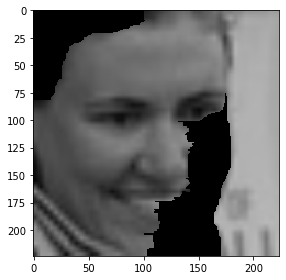

In [15]:
skimage.io.imshow(perturbed_img)
plt.show()

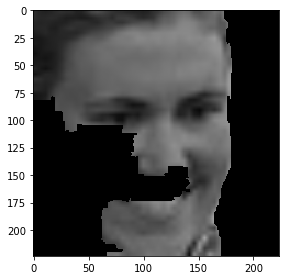

In [16]:
skimage.io.imshow(perturbed_img2)
plt.show()

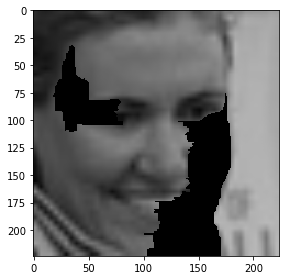

In [17]:
skimage.io.imshow(perturbed_img3)
plt.show()

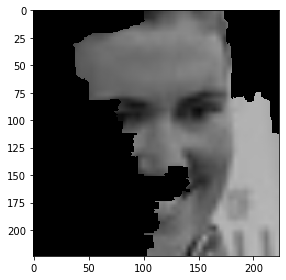

In [18]:
## Angry perturbation

skimage.io.imshow(perturb_image(gray_resized, perturbations_gray[2], superpixels_gray))
plt.show()

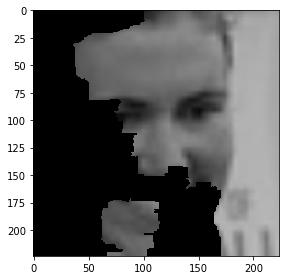

In [19]:
## Angry perturbation

skimage.io.imshow(perturb_image(gray_resized, perturbations_gray[87], superpixels_gray))
plt.show()

#### Interpretation

The results for the `grayscale` image are straightforward. There are no confusions in predicting the **happy** emotion category. What we can discuss, are the 'most' relevant parts of the face that lead the **FER** model to decide on **happy** as the top emotion. 

For that, we will focus on the top three perturbations, presented above (with the lowest Euclidean distance). We can see that in all three images eyes and mouth are almost fully uncovered. In our opinion, this means in order to predict **happy** as the top emotion, eyes and mouth are very important for the model. This could be influenced by the data the model has trained on, but to prove that, we would need to test out many images. But for our image, we can say, that these parts are important. Other than that, covering the left cheek, as well as the right one, do not change the model's prediction, i.e. when not covered at the same time, they are not relevant for the predictions. Nose is a tricky one to decide on, since in the case of the second perturbation it is covered a bit, but not fully, so we cannot really decide on that.  

Last but not least, we included an example of two perturbations when the model predicts wrong. As we can see on the first perturbed image, the mouth and one eye are half-covered, while one cheek is fully covered too. On the second image, the face is covered almost the same as in the first image with the mouth being more covered. We have mentioned already the importance of mouth and eyes, i.e without the uncovered mouth and eyes, in our opinion, the model will most likely predict wrong for our image.

---

`Coloured` image:

In [20]:
result = list()
np.random.seed(1234)

for lista in colour_predictions:
    if len(lista) != 0:
        if (1 - spatial.distance.euclidean(lista[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))], captured_emotions_colour[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))])) != 1.0:
            result.append([spatial.distance.euclidean(lista[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))], captured_emotions_colour[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))]), colour_predictions.index(lista), max(lista[0]['emotions'], key = lista[0]['emotions'].get)])
            
sorted_result = sorted(result)
print(sorted_result)

[[0.010000000000000009, 80, 'surprise'], [0.020000000000000018, 1, 'surprise'], [0.020000000000000018, 94, 'surprise'], [0.07000000000000006, 12, 'surprise'], [0.08000000000000007, 71, 'surprise'], [0.08999999999999997, 11, 'surprise'], [0.13999999999999999, 67, 'neutral'], [0.13999999999999999, 78, 'neutral'], [0.15, 45, 'neutral'], [0.16, 4, 'neutral'], [0.16, 5, 'neutral'], [0.16, 51, 'neutral'], [0.16999999999999993, 40, 'surprise'], [0.17000000000000004, 64, 'surprise'], [0.21, 16, 'neutral'], [0.23000000000000004, 3, 'surprise'], [0.24000000000000005, 32, 'surprise'], [0.24999999999999997, 14, 'neutral'], [0.24999999999999997, 38, 'fear'], [0.26, 2, 'surprise'], [0.26, 27, 'neutral'], [0.27, 77, 'neutral'], [0.28, 35, 'neutral'], [0.28, 42, 'neutral'], [0.28, 43, 'surprise'], [0.30999999999999994, 63, 'neutral'], [0.31999999999999995, 96, 'neutral'], [0.33999999999999997, 18, 'neutral'], [0.33999999999999997, 18, 'neutral'], [0.36, 48, 'angry'], [0.37, 44, 'sad'], [0.38, 19, 'fea

As we can see, the first few top emotion predictions on each perturbed `coloured` image have the lowest Euclidean distance with the prediction of the original **FER** model. In our opinion, they are the most relevant for the **FER** model.

Let's show an example of few most important perturbations:

In [21]:
if sorted_result[0][2] == 'surprise':
    num_pert = sorted_result[0][1]
if sorted_result[1][2] == 'surprise':
    num_pert2 = sorted_result[1][1]
if sorted_result[2][2] == 'surprise':
    num_pert3 = sorted_result[2][1]

perturbed1 = perturb_image(coloured_img, perturbations[num_pert], superpixels)
perturbed2 = perturb_image(coloured_img, perturbations[num_pert2], superpixels)
perturbed3 = perturb_image(coloured_img, perturbations[num_pert3], superpixels)

emo11 = FER(mtcnn = True)
emo22 = FER(mtcnn = True)
emo33 = FER(mtcnn = True)

pred11 = emo11.detect_emotions(perturbed1)
pred22 = emo22.detect_emotions(perturbed2)
pred33 = emo33.detect_emotions(perturbed3)

print(pred11)
print(pred22)
print(pred33)

[{'box': (471, 114, 164, 164), 'emotions': {'angry': 0.01, 'disgust': 0.0, 'fear': 0.04, 'happy': 0.1, 'sad': 0.04, 'surprise': 0.67, 'neutral': 0.14}}]
[{'box': (466, 115, 168, 168), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.03, 'happy': 0.05, 'sad': 0.03, 'surprise': 0.64, 'neutral': 0.25}}]
[{'box': (466, 115, 168, 168), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.02, 'happy': 0.06, 'sad': 0.03, 'surprise': 0.68, 'neutral': 0.21}}, {'box': (609, 508, 39, 39), 'emotions': {'angry': 0.17, 'disgust': 0.0, 'fear': 0.42, 'happy': 0.17, 'sad': 0.19, 'surprise': 0.0, 'neutral': 0.05}}, {'box': (464, 565, 79, 79), 'emotions': {'angry': 0.37, 'disgust': 0.0, 'fear': 0.09, 'happy': 0.06, 'sad': 0.32, 'surprise': 0.02, 'neutral': 0.14}}]


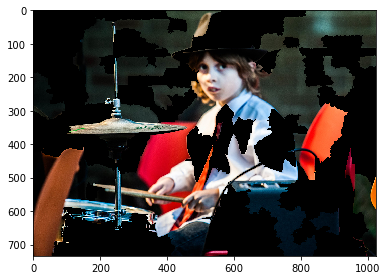

In [22]:
skimage.io.imshow(perturbed1)
plt.show()

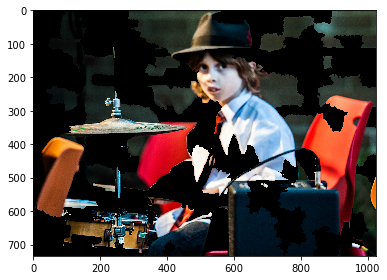

In [23]:
skimage.io.imshow(perturbed2)
plt.show()

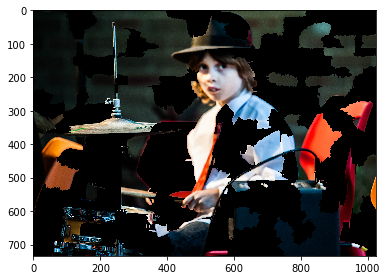

In [24]:
skimage.io.imshow(perturbed3)
plt.show()

#### Interpretation

As seen above, the most dominant emotion that the **FER** model predicts is surprise. While perturbing the image 100 times, there are many more instances when **FER** model can detect emotions than in the case of `grayscale` image (Another reason is the colour of the image!). Why is that the case? When we take a look at the `grayscale` and `coloured` top three emotion predictions with the lowest Euclidean distance, we can notice that in the case of the `coloured` image, the face of the person on the image is almost fully uncovered, meaning the model predicts almost the same as in the case of all superpixels enabled. This is because **FER** model does not need the segments outside of the face bounding box to predict. It uses Haar-Cascade classifier and MTCNN (when mtcnn = True is enabled) for better accuracy to find the face bounding box.
Because of the described challenge, we want to test out the cropped `coloured` image predictions and decide whether it would lead to more relevant descriptions.

---
`Cropped coloured` image:

We wanted to test out how the whole code above will work if the coloured image was cropped. The reason for this is that the probability of the dominant emotion does indeed rise when the image is zoomed in. Another reason (maybe more relevant for LIME) is that the face bounding box usually stays the same, i.e. hiding the parts of the face more, rather than hiding segments of the image around the face bounding box (in this case, the segmentation wouldn't help us identify parts of the face relevant for the predictions). This makes it easier to pin-point the parts of the image that are relevant for predictions. 

The code below is just the repetition of the code from above, just creating new variables for the cropped image.

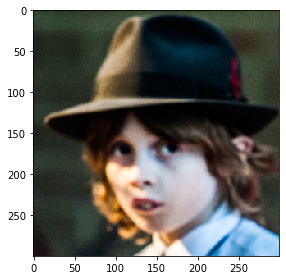

In [25]:
cropped = coloured_img[0:300,400:700]
skimage.io.imshow(cropped)
plt.show()

In [26]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

emo_detector_crop = FER(mtcnn = True)
captured_emotions_crop = emo_detector_crop.detect_emotions(cropped)

# Print all captured emotions with the image
print(captured_emotions_crop)

emotions_crop = []
for dicto in captured_emotions_crop:
    dominant_crop = max(dicto['emotions'].values())
    for emotion, score in dicto['emotions'].items():
        if score == dominant_crop:
            emotions_crop.append(emotion)
            
y = dict(sorted(captured_emotions_crop[0]['emotions'].items(), key=operator.itemgetter(1), reverse=True)[:5])
print("Top 5 classes: ", y)

[{'box': (67, 117, 166, 166), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.05, 'sad': 0.01, 'surprise': 0.83, 'neutral': 0.1}}]
Top 5 classes:  {'surprise': 0.83, 'neutral': 0.1, 'happy': 0.05, 'fear': 0.01, 'sad': 0.01}


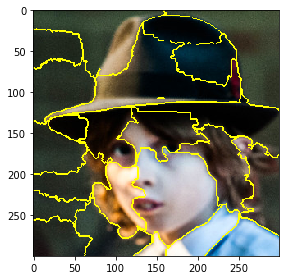

In [27]:
import skimage.segmentation
np.random.seed(1234)

superpixels_crop = skimage.segmentation.quickshift(cropped, kernel_size = 7, max_dist = 100, ratio = 0.8)
num_superpixels_crop = np.unique(superpixels_crop).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(cropped, superpixels_crop))

#Generate perturbations
num_perturb_crop = 100
perturbations_crop = np.random.binomial(1, 0.5, size=(num_perturb_crop, num_superpixels_crop))

#Create function to apply perturbations to images
import copy
def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image.astype('uint8')

Perturbation 6 for the cropped coloured image is: 
[0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0]


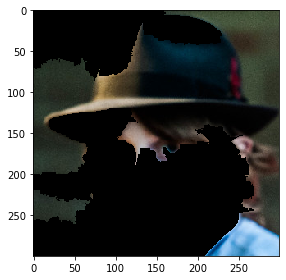

In [28]:
print('Perturbation 6 for the cropped coloured image is: ')
print(perturbations_crop[5]) 
img_test_crop = perturb_image(cropped, perturbations_crop[5], superpixels_crop)
skimage.io.imshow(img_test_crop)
plt.show()

In [29]:
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

crop_predictions = []
for pert in perturbations_crop:
    perturbed_img_crop= perturb_image(cropped, pert, superpixels_crop)
    emo_crop = FER(mtcnn = True)
    pred_crop = emo_crop.detect_emotions(perturbed_img_crop)
    crop_predictions.append(pred_crop)
        
print(crop_predictions)

[[{'box': (78, 116, 162, 162), 'emotions': {'angry': 0.11, 'disgust': 0.0, 'fear': 0.04, 'happy': 0.01, 'sad': 0.08, 'surprise': 0.02, 'neutral': 0.74}}], [{'box': (84, 121, 150, 150), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.01, 'sad': 0.02, 'surprise': 0.05, 'neutral': 0.92}}], [], [{'box': (86, 132, 141, 141), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.16, 'sad': 0.03, 'surprise': 0.38, 'neutral': 0.42}}], [], [], [], [{'box': (78, 113, 166, 166), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.0, 'sad': 0.09, 'surprise': 0.01, 'neutral': 0.89}}], [{'box': (95, 136, 137, 137), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 0.01, 'sad': 0.01, 'surprise': 0.0, 'neutral': 0.98}}], [], [{'box': (58, 88, 196, 196), 'emotions': {'angry': 0.34, 'disgust': 0.0, 'fear': 0.02, 'happy': 0.0, 'sad': 0.18, 'surprise': 0.01, 'neutral': 0.44}}], [{'box': (79, 143, 86, 86), 'emotions': {'angry': 0.11, 'disgust

In [30]:
import sklearn
import sklearn.metrics
from scipy import spatial
np.random.seed(1234)

result_crop = list()

for lista in crop_predictions:
    if len(lista) != 0:
        if (1 - spatial.distance.euclidean(lista[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))], captured_emotions_crop[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))])) != 1.0:
            result_crop.append([spatial.distance.euclidean(lista[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))], captured_emotions_crop[0]['emotions'][(max(lista[0]['emotions'], key = lista[0]['emotions'].get))]), crop_predictions.index(lista), max(lista[0]['emotions'], key = lista[0]['emotions'].get)])
            
sorted_result_crop = sorted(result_crop)
print(sorted_result_crop)

[[0.21999999999999997, 78, 'surprise'], [0.25, 22, 'surprise'], [0.26, 95, 'surprise'], [0.27, 45, 'neutral'], [0.2899999999999999, 56, 'surprise'], [0.30999999999999994, 15, 'neutral'], [0.31999999999999995, 3, 'neutral'], [0.32999999999999996, 11, 'neutral'], [0.32999999999999996, 11, 'neutral'], [0.32999999999999996, 11, 'neutral'], [0.32999999999999996, 93, 'neutral'], [0.33999999999999997, 10, 'neutral'], [0.33999999999999997, 55, 'neutral'], [0.33999999999999997, 91, 'surprise'], [0.35, 27, 'surprise'], [0.35, 41, 'neutral'], [0.35, 49, 'neutral'], [0.36, 19, 'surprise'], [0.37, 26, 'neutral'], [0.37999999999999995, 44, 'surprise'], [0.38, 17, 'neutral'], [0.38, 65, 'sad'], [0.38, 73, 'neutral'], [0.38, 89, 'sad'], [0.39, 24, 'neutral'], [0.41000000000000003, 77, 'neutral'], [0.42999999999999994, 21, 'surprise'], [0.43999999999999995, 36, 'surprise'], [0.44000000000000006, 75, 'neutral'], [0.4600000000000001, 52, 'neutral'], [0.4600000000000001, 79, 'neutral'], [0.460000000000000

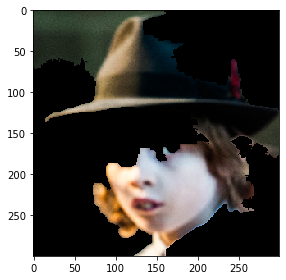

In [31]:
p = perturb_image(cropped, perturbations_crop[sorted_result_crop[0][1]], superpixels_crop)
skimage.io.imshow(p)
plt.show()

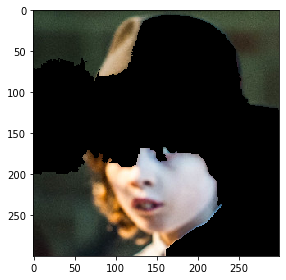

In [32]:
skimage.io.imshow(perturb_image(cropped, perturbations_crop[sorted_result_crop[1][1]], superpixels_crop))
plt.show()

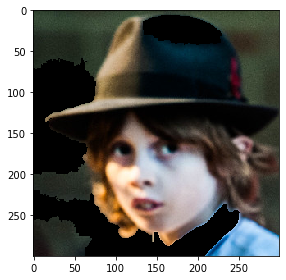

In [33]:
skimage.io.imshow(perturb_image(cropped, perturbations_crop[sorted_result_crop[2][1]], superpixels_crop))
plt.show()

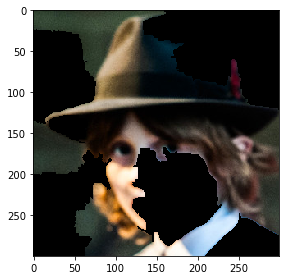

In [34]:
### Neutral emotion category prediction

skimage.io.imshow(perturb_image(cropped, perturbations_crop[45], superpixels_crop))
plt.show()

#### Interpretation

In the case of the `cropped coloured` image, the **FER** model still predicts **surprise** with higher probability (83%) than in the original `coloured` image (66%). The reason for that could be the data that **FER** model was trained on (zoomed images, smaller images, coloured/grayscale images etc.). One interesting thing we can notice here is that the predictions of dominant emotions with the lowest Euclidean distance are not only **surprise** (like in the case of the original image), but there are a lot of **neutral** emotion category predictions.

WHY are there so many **neutral** emotion category predictions?

In our opinion, very important for the **FER** model to recognize surprise in this image are the lips. In the result above, the lowest Euclidean distance is calculated for perturbation at the index 0 of the sorted_result_crop list. In many other cases above, where the model predicts **neutral**, the lips are covered. This could mean, that the images on which the model has trained to recognize surprise probably mostly include specific mouth shape. This is again just an assumption.